##### Last modified: Nov 15th, 2021 (Opal)

# Cross-Correlation

# Background

## Definition 

Cross-correlation is a measure of similarity of two series as a function of the displacement of one relative to the other. This is also known as a sliding dot product or sliding inner-product.If $X$ and $Y$ are two independent random variables with probability density functions $f$ and $g$, respectively, then the probability density of the difference $Y-X$ is formally given by the cross-correlation

The cross-correlation of two *continuous* function $f(x)$ and $g(x)$ denoted by $f \ast g$ is defined as
\begin{equation}
(f \ast g)(\tau) \equiv \int_{-\infty}^{\infty} \overline{f(\tau)} g(x + \tau) d \tau
\end{equation}

where $\overline{f(\tau)}$ denotes the complex conjugate of ${f(\tau)}$.

For finite discrete functions $f, g \in \mathbb{C}^{N}$, the circular (periodic) cross-correlation is defined as 
\begin{equation}
(f \ast g)[n] \equiv \sum_{m=0}^{N-1} \overline{f[m]} g[m +n]_{\text{mod N}}] 
\end{equation}

### Motivation to use to find spatial shifting in convective-dominated problems
When the functions align/correlate, the value of $(f \ast g)$ is maximized. This is because when peaks (positive areas) are aligned, they make a large contribution to the integral. Similarly, when troughs (negative areas) align, they also make a positive contribution to the integral because the product of two negative numbers is positive.

### Circular convolution theorem and cross-correlation theorem
Given sequences $x$ and $y_{N}$, where $y_{N}$ is N-periodic, then the cross-correlation of $x$ and $y_{N}$ is given by 
$$
x \ast y_{N} \equiv \mathcal{F}^{-1}\{ \overline{\mathcal{F}\{x\}} \cdot \mathcal{F}{\{y\}\}}
$$

where $\mathcal{F}$ denotes the Fourier transform, and $\overline{\mathcal{F}\{x\}}$ indicates the complex conjugate of $\mathcal{F}\{x\}$. This is analogous to the convolution theorem.




# TODO: 
1. MHD 1D SLICES. $\checkmark$
2. MHD 2D SLICES. $\checkmark$
3. HUX 1D SLICES. (A comparison of technqiues) $\checkmark$

In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM


In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy import signal
import scipy
from scipy.ndimage import correlate
from numpy.fft import fft, ifft
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
import numpy as np 
import time
import astropy.units as u

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

In [4]:
from code.hux_propagation import *
from code.archimedes_sprial import compute_phi_shift_forward
from code.numerical_methods import apply_numerical_method

ModuleNotFoundError: No module named 'code.hux_propagation'; 'code' is not a package

# Import MHD dataset

In [5]:
# mas output - br, rho, vr
mas_path = get_mas_path(cr="2210")
model = MASOutput(mas_path)
print(model.variables)

['br', 'rho', 'vr']


In [6]:
# read in MHD velocity results. 
vr_model = model['vr']

In [7]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
r = (vr_model.r_coords * u.solRad).to(u.AU)
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


# Create Finer Longitude Grid (uniform) 
n_prev = 128, n_curr = 500

In [8]:
p_new = np.linspace(p[0], p[-1], 500)

f_new = np.zeros((len(p_new), len(t), len(r)))

In [9]:
for ii in range(len(r)):
    v_interp = interp2d(p, t, f[:, :, ii].T, fill_value="extrapolate")
    f_new[:, :, ii] = v_interp(p_new, t).T

In [10]:
r1, r2 = 10, 90
v1 = f_new[:, 55, r1]
v2 = f_new[:,55, r2]

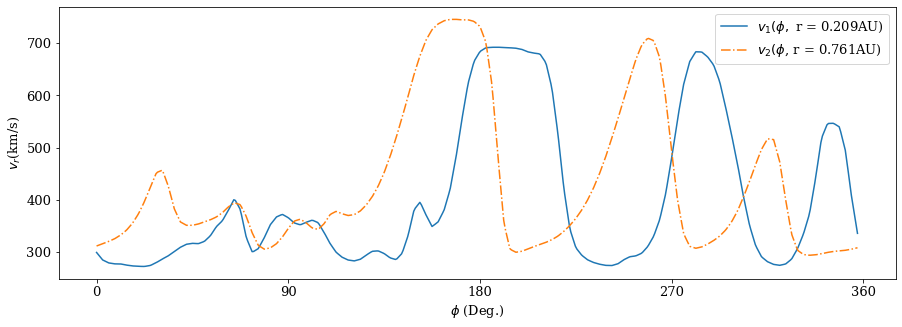

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.plot(180*p_new/np.pi, v1, ls= "-", label="$v_{1}(\phi, $ r = "+ str(round(r[r1].value, 3)) + "AU)")
_ = ax.plot(180*p_new/np.pi, v2, ls="-.", label="$v_{2}(\phi$, r = " + str(round(r[r2].value, 3)) + "AU)")
_ = ax.set_xticks([0, 90, 180, 270, 360])
_ = ax.set_xlabel("$\phi$ (Deg.)")
_ = ax.set_ylabel("$v_{r}$(km/s)")
_ = plt.legend()

# Non-periodic cross-correlation

In [12]:
def normalize(x):
    return (x - np.mean(x))/np.std(x)

In [13]:
corr = signal.correlate(normalize(v1), normalize(v2),  method="fft")
corr /= np.max(corr)
lags = signal.correlation_lags(len(v1), len(v2))

In [14]:
plags = []
for ii in lags:
    if ii <= 0:
        plags.append(-180*p_new[-ii]/np.pi)
    else:
        plags.append(180*p_new[ii]/np.pi)

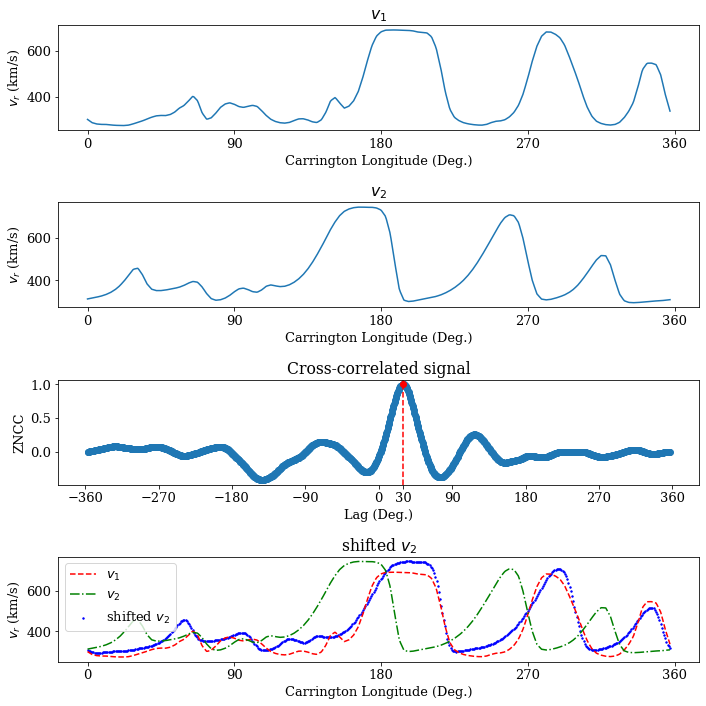

In [15]:
fig, (ax_v1, ax_v2, ax_corr, ax_lap) = plt.subplots(4, 1, figsize=(10, 10))
ax_v1.plot(180*p_new/np.pi, v1)
ax_v1.set_title('$v_{1}$')
ax_v1.set_xlabel('Carrington Longitude (Deg.)')
ax_v1.set_ylabel('$v_{r}$ (km/s)')
ax_v1.set_xticks([0, 90, 180, 270, 360])

ax_v2.plot(180*p_new/np.pi, v2)
ax_v2.set_title('$v_{2}$')
ax_v2.set_xlabel('Carrington Longitude (Deg.)')
ax_v2.set_ylabel('$v_{r}$ (km/s)')
ax_v2.set_xticks([0, 90, 180, 270, 360])


ax_corr.scatter(plags, corr)
shift = plags[np.argmax(corr)]
ax_corr.scatter(shift, np.max(corr), c="r")
ax_corr.axvline(x=shift, linestyle="--", c="r")
ax_corr.set_xticks([360, 270, 180, 90, 0, round(plags[np.argmax(corr)]), -90, -180, -270, -360])
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag (Deg.)')
ax_corr.set_ylabel("ZNCC")

if np.argmax(corr) < len(p):
    index_roll = len(p_new) - np.argmax(corr)
else:
    index_roll = np.argmax(corr) - len(p_new)
ax_lap.plot(180/np.pi*p_new, v1, c="r", linestyle="--", label="$v_{1}$")
ax_lap.plot(180/np.pi*p_new, v2, c="g", linestyle="-.", label="$v_{2}$")
ax_lap.scatter(180/np.pi*np.roll(p_new, shift=-index_roll), v2, c="b", s=2, label="shifted $v_{2}$")

ax_lap.set_xticks([0, 90, 180, 270, 360])
ax_lap.set_title('shifted $v_{2}$')
ax_lap.set_xlabel('Carrington Longitude (Deg.)')
ax_lap.set_ylabel("$v_{r}$ (km/s)")


ax_lap.legend()
fig.tight_layout()

# Periodic Cross-Correlation

In [16]:
def periodic_corr(x, y):
    """Periodic correlation, implemented using the FFT.
    x and y must be real sequences with the same length.
    """
    return ifft(fft(x).conj() * fft(y)).real

def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')

In [17]:
res2 = periodic_corr_np(normalize(v1), normalize(v2))
res2 /= np.max(res2)

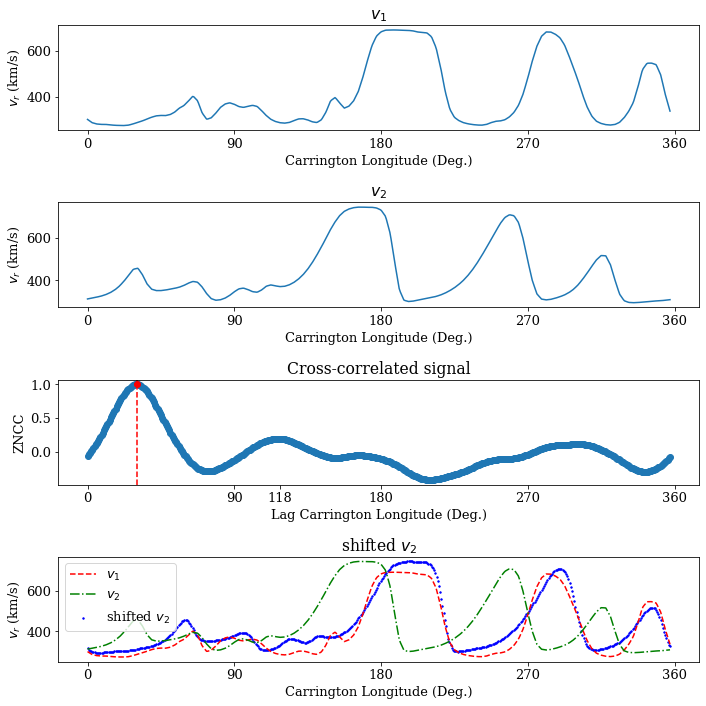

In [18]:
fig, (ax_v1, ax_v2, ax_corr, ax_lap) = plt.subplots(4, 1, figsize=(10, 10))
ax_v1.plot(180*p_new/np.pi, v1)
ax_v1.set_title('$v_{1}$')
ax_v1.set_xlabel('Carrington Longitude (Deg.)')
ax_v1.set_ylabel('$v_{r}$ (km/s)')
ax_v1.set_xticks([0, 90, 180, 270, 360])

ax_v2.plot(180*p_new/np.pi, v2)
ax_v2.set_title('$v_{2}$')
ax_v2.set_xlabel('Carrington Longitude (Deg.)')
ax_v2.set_ylabel('$v_{r}$ (km/s)')
ax_v2.set_xticks([0, 90, 180, 270, 360])


ax_corr.scatter(180*p_new/np.pi, res2)
ax_corr.scatter(p_new[np.argmax(res2)]*180/np.pi, np.max(res2), c="r")
ax_corr.axvline(x=p_new[np.argmax(res2)]*180/np.pi, linestyle="--", c="r")

ax_corr.set_xticks([360, 270, 180, 90, 0, round(p[np.argmax(res2)]*180/np.pi)])
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag Carrington Longitude (Deg.)')
ax_corr.set_ylabel("ZNCC")



if np.argmax(res2) < len(p):
    index_roll = len(p_new) - np.argmax(res2)
else:
    index_roll = np.argmax(res2) - len(p_new)
ax_lap.plot(180/np.pi*p_new, v1, c="r", linestyle="--", label="$v_{1}$")
ax_lap.plot(180/np.pi*p_new, v2, c="g", linestyle="-.", label="$v_{2}$")
ax_lap.scatter(180/np.pi*np.roll(p_new, shift=index_roll), v2, c="b", s=2, label="shifted $v_{2}$")

ax_lap.set_xticks([0, 90, 180, 270, 360])
ax_lap.set_title('shifted $v_{2}$')
ax_lap.set_xlabel('Carrington Longitude (Deg.)')
ax_lap.set_ylabel("$v_{r}$ (km/s)")

plt.legend()
fig.tight_layout()

# Apply cross-correlation to all slices

In [19]:
v1 = f_new[:, 55, 0]
shift_vec = [0]
for ii in range(1, len(r)):
    v2 = f_new[:, 55, ii]
    corr = periodic_corr_np(normalize(v1), normalize(v2))
    corr = corr/np.max(corr)
    shift_vec.append(p_new[np.argmax(corr)]*180/np.pi)

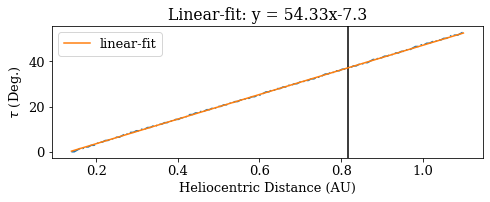

In [31]:
fig, ax = plt.subplots(figsize=(7, 3))
# plot the shifted data.
_ = ax.plot(r, shift_vec, ls="-.")

# given only 70%. of the training data- can we extrapolate?
n = int(len(r)*0.7)
m, b = np.polyfit(r[:n].value, shift_vec[:n], 1)
plt.axvline(x=r[n].value, c="k")
_ = ax.plot(r, m*r.value + b, label="linear-fit")

_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel(r"$\tau$ (Deg.)")
_ = ax.set_title("Linear-fit: y = " + str(round(m, 2)) + "x" + str(round(b, 2)))
_ = plt.legend()

_ = plt.tight_layout()
plt.savefig("CrossCorrelation/figs/cross-correlation-shift-500np.png", dpi=500)

In [21]:
V_new = np.zeros((len(p_new), len(r)))
V_new[:, 0] = f_new[:, 55, 0]

for jj in range(1, len(r)):
    f_interp = interp1d(p_new*180/np.pi, f_new[:,55, jj], fill_value="extrapolate", bounds_error=False)
    x_new = (p_new*180/np.pi - shift_vec[jj]) % (360)
    V_new[:, jj] = f_interp(x_new)

In [22]:
def plot_heat_data(Z, title, sample_columns=np.arange(0, len(r), 15), variable="v", xlabel="$\phi$ (Deg.)", ylabel="$v_{r}$ ( km/s)",
                  save_fig=False, file_name=None):
    
    fig, ax = plt.subplots(figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p_new*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r$" + "=" + 
                str(round(r[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(ylabel, fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.suptitle(title, fontsize=15)
    
    if save_fig:
        fig.savefig(file_name, dpi=300, bbox_inches='tight')

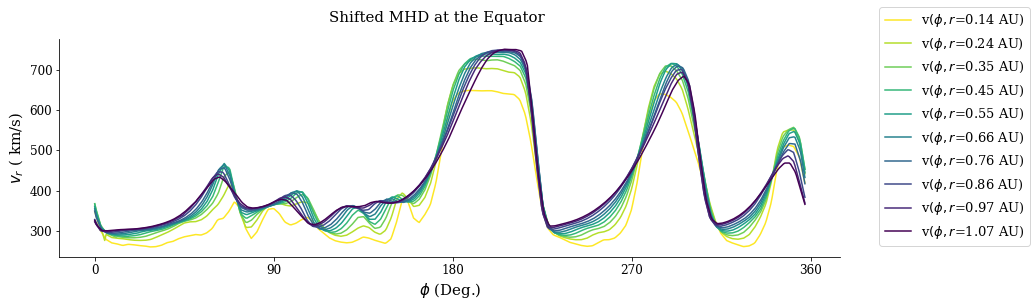

In [23]:
plot_heat_data(V_new, title="Shifted MHD at the Equator")

# Apply Circular Cross-Correlation to 2D MHD Data

In [24]:
v1 = f_new[:, :, r1]
v2 = f_new[:, :, r2]

In [25]:
def periodic_corr_2d(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return scipy.signal.correlate2d(x, np.concatenate((y[1:, :], y)), mode='valid')

In [26]:
res = periodic_corr_2d(normalize(v1), normalize(v2))
res/= np.max(res)

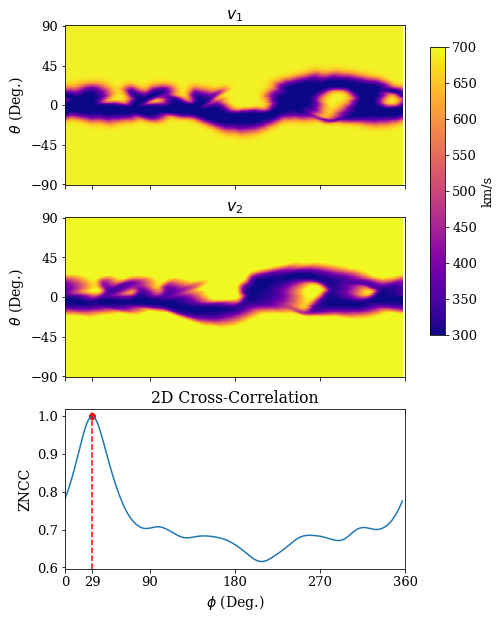

In [27]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(7, 10))

ax[0].imshow(v1.T,
                extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[0].set_title("$v_{1}$")
im = ax[1].imshow(v2.T,
                extent=[p_new[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")

ax[1].set_title("$v_{2}$")
ax[2].plot(180*p_new/np.pi, res)
ax[2].axvline(x=p_new[np.argmax(res)]*180/np.pi, linestyle="--", c="r")
ax[2].scatter(p_new[np.argmax(res)]*180/np.pi, np.max(res), c="r")
ax[2].set_xticks([360, 270, 180, 90, 0, round(p_new[np.argmax(res)]*180/np.pi)])
ax[2].set_title("2D Cross-Correlation")

ax[2].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
ax[1].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
ax[2].set_ylabel(r"ZNCC", fontsize=14)
ax[0].set_yticks([-90, -45, 0, 45, 90])
ax[1].set_yticks([-90, -45, 0, 45, 90])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.03, 0.4])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel('km/s', rotation=90)

plt.savefig("figs/velocity_shifted_2d.png")

In [28]:
p_shifted = (p_new - p_new[np.argmax(res)]) % (p_new[-1]) 


In [29]:
my_interpolating_function = RegularGridInterpolator((p_new, t), v2)

In [30]:
v2_shifted = np.zeros(v2.shape)
for ii, pp in enumerate(p_shifted):
    for jj, tt in enumerate(t):
        point = np.array([pp, tt])
        v2_shifted[ii, jj] = my_interpolating_function(point)

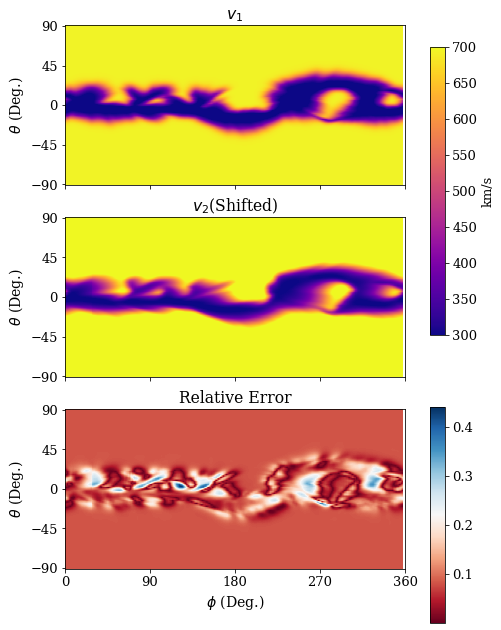

In [31]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(7, 10))

ax[0].imshow(v1.T,
                extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[0].set_title("$v_{1}$")


im = ax[1].imshow(v2_shifted.T,
                extent=[p[0]*180/np.pi, p_new[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")

ax[1].set_title("$v_{2}$(Shifted)")

im2 = ax[2].imshow(np.abs(v1.T - v2_shifted.T)/np.abs(v1.T),
                extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi], cmap="RdBu", aspect="auto")
cbar_ax = fig.add_axes([0.85, 0.05, 0.03, 0.3])
fig.colorbar(im2, cax=cbar_ax)


ax[2].set_xticks([360, 270, 180, 90, 0])
ax[2].set_title("Relative Error")

ax[2].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
ax[1].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
ax[2].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
ax[0].set_yticks([-90, -45, 0, 45, 90])
ax[1].set_yticks([-90, -45, 0, 45, 90])
ax[2].set_yticks([-90, -45, 0, 45, 90])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.03, 0.4])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel('km/s', rotation=90)

plt.savefig("figs/velocity_shifted_abs_difference_heatmap.png")

# Apply Cross-Correlation to all 2D slices

In [92]:
v1 = f_new[:, :, 0]

shift_vec_2d = [0]

for ii in range(1, len(r)):
    v2 = f_new[:, :, ii]
    corr = periodic_corr_2d(normalize(v1), normalize(v2))
    corr = corr/np.max(corr)
    shift_vec_2d.append(p_new[np.argmax(corr)]*180/np.pi)

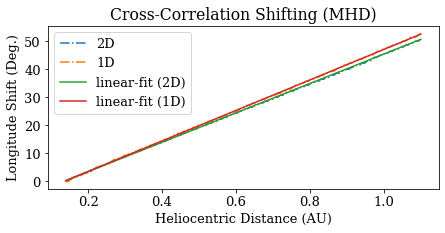

In [93]:
fig, ax = plt.subplots(figsize=(7, 3))
# plot the shifted data.
_ = ax.plot(r, shift_vec_2d, ls="-.", label="2D")
_ = ax.plot(r, shift_vec, ls="-.", label="1D")


# given only 50%. of the training data- can we extrapolate?
n = int(len(r)*0.5)
m, b = np.polyfit(r[:n].value, shift_vec_2d[:n], 1)
_ = ax.plot(r, m*r.value + b, label="linear-fit (2D)")

m, b = np.polyfit(r[:n].value, shift_vec[:n], 1)
_ = ax.plot(r, m*r.value + b, label="linear-fit (1D)")

_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("Longitude Shift (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting (MHD)")
_ = plt.legend()

# Cross-Correlation to HUX dataset (compare with method of characteristics)

In [94]:
HUX_V = apply_hux_f_model(f_new[:, 55, 0], (r[1:]-r[:-1]).to(u.km).value, p_new[1:] -p_new[:-1]).T

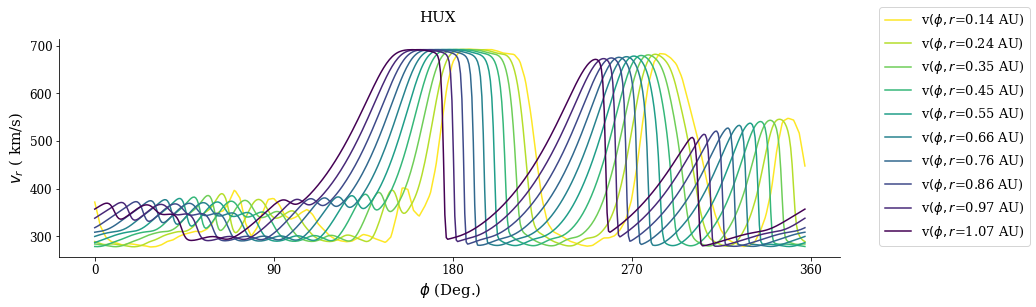

In [95]:
plot_heat_data(HUX_V, title="HUX")

# Cross-Correlation for all slices in comparison to the initial condition

In [97]:
v1 = HUX_V[:, 0]
shift_vec_hux = [0]
for ii in range(1, len(r)):
    v2 = HUX_V[:, ii]
    corr = periodic_corr_np(normalize(v1), normalize(v2))
    corr = corr/np.max(corr)
    shift_vec_hux.append(p_new[np.argmax(corr)]*180/np.pi)

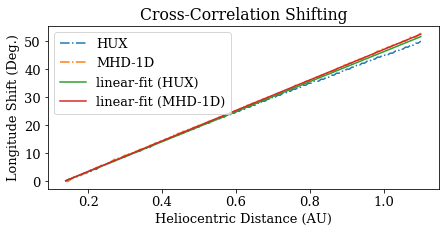

In [98]:
fig, ax = plt.subplots(figsize=(7, 3))
# plot the shifted data.
_ = ax.plot(r, shift_vec_hux, ls="-.", label="HUX")
_ = ax.plot(r, shift_vec, ls="-.", label="MHD-1D")

# given only 50%. of the training data- can we extrapolate?
n = int(len(r)*0.5)
m, b = np.polyfit(r[:n].value, shift_vec_hux[:n], 1)
_ = ax.plot(r, m*r.value + b, label="linear-fit (HUX)")

# given only 50%. of the training data- can we extrapolate?
n = int(len(r)*0.5)
m, b = np.polyfit(r[:n].value, shift_vec[:n], 1)
_ = ax.plot(r, m*r.value + b, label="linear-fit (MHD-1D)")

_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("Longitude Shift (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting")
_ = plt.legend()

# Method of Characteristics vs. Cross-Correlation

In [99]:
def compute_phi_shift_forward(p, r, v, omega=(2 * np.pi) / (25.38 * 86400), method=None):
    # initialize phi shift matrix. 
    phi_shift_mat = np.zeros((len(r), len(p)))
    
    # phi at index 0 is original phi grid 
    phi_shift_mat[0, :] = np.zeros(len(p))
    
    # delta r.
    dr = np.mean(r[1:] - r[:-1])
    
    # compute the phi shift for each idx in r. 
    for ii in range(len(r)-1):
        if method == "ballistic":
            phi_shift = -(omega/v[:, 0])*dr
        else:
            phi_shift = -(omega/v[:, ii])*dr
        phi_shift_mat[ii+1, :] = phi_shift_mat[ii, :] + phi_shift
        
    return phi_shift_mat

In [100]:
phi_shift = compute_phi_shift_forward(p_new, r.to(u.km).value, HUX_V, method="ballistic")

In [114]:
peak_b = 200
peak_e = 300

In [115]:
avg_shift_vec = np.zeros(len(r))

V_new[:, 0] = HUX_V[:, 0]
for jj in range(1, len(r)):
    avg_shift = np.mean(phi_shift[jj, peak_b: peak_e]) #+np.std(phi_shift[jj, :])
    avg_shift_vec[jj] = avg_shift

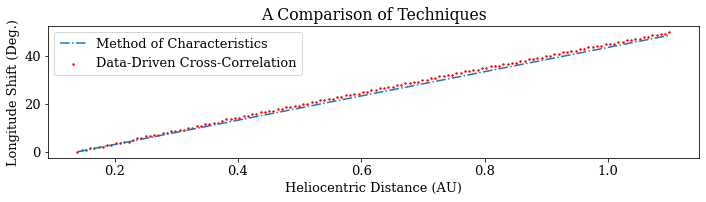

In [117]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.plot(r.to(u.AU), -avg_shift_vec*180/np.pi, ls="-.", label="Method of Characteristics")
ax.scatter(r.to(u.AU), shift_vec_hux, s=2, c="r", label="Data-Driven Cross-Correlation")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("Longitude Shift (Deg.)")
_ = ax.set_title("A Comparison of Techniques")
_ = plt.legend()
_ = plt.tight_layout()

plt.savefig("figs/comparison-of-techniques-cc-np500.png")

In [36]:
HUX_V.shape

(128, 140)